In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array
from tensorflow import keras
from keras import layers, activations, losses, optimizers, metrics, callbacks, utils

2023-09-13 18:19:43.243674: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
input_dir = 'ch9/images/'
target_dir = 'ch9/annotations/trimaps/'

def get_paths(dir, ext):
    return sorted([os.path.join(dir, filename) for filename in os.listdir(dir) if filename.endswith(ext) and not filename.startswith('.')])

input_img_paths = get_paths(input_dir, '.jpg')
target_paths = get_paths(target_dir, '.png')

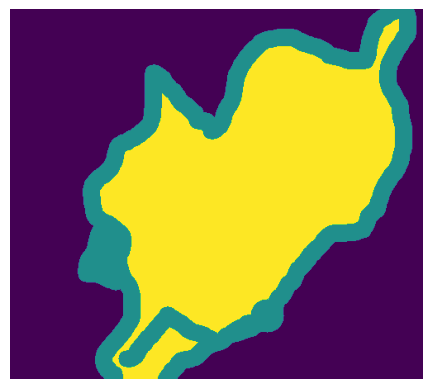

In [3]:
plt.axis('off')
plt.imshow(load_img(input_img_paths[9]))

def display_target(target_array):
    normalized_array = target_array.astype(np.int8) * 85
    plt.axis('off')
    plt.imshow(normalized_array)

a = load_img(target_paths[9], color_mode='grayscale')
b = img_to_array(a)
display_target(b)

In [4]:
img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_img(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode='grayscale'))
    img = img.astype(np.uint8) - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype=np.float32)
targets = np.zeros((num_imgs,) + img_size + (1,), dtype=np.uint8)
for i in range(num_imgs):
    input_imgs[i] = path_to_input_img(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

In [5]:
num_val_samples = 1000

train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [6]:
def get_model(img_size, num_classes):
    inputs = layers.Input(img_size + (3,))
    x = layers.Rescaling(1/255)(inputs)

    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation=activations.relu, padding='same')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation=activations.relu, padding='same')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation=activations.relu, padding='same')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation=activations.relu, padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, strides=2, activation=activations.relu, padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation=activations.relu, padding='same')(x)

    x = layers.Conv2DTranspose(filters=256, kernel_size=3, activation=activations.relu, padding='same')(x)
    x = layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, activation=activations.relu, padding='same')(x)
    x = layers.Conv2DTranspose(filters=128, kernel_size=3, activation=activations.relu, padding='same')(x)
    x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, activation=activations.relu, padding='same')(x)
    x = layers.Conv2DTranspose(filters=64, kernel_size=3, activation=activations.relu, padding='same')(x)
    x = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation=activations.relu, padding='same')(x)

    outputs = layers.Conv2D(filters=num_classes, kernel_size=3, activation=activations.softmax, padding='same')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()
    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

2023-09-13 18:19:56.169804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-13 18:19:56.172282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-13 18:19:56.172381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=[metrics.SparseCategoricalAccuracy()])

callback_list = [
    callbacks.ModelCheckpoint('oxford_seg', save_best_only='True')
]

history = model.fit(train_input_imgs, train_targets, epochs=75, callbacks=callback_list, batch_size=64, validation_data=(val_input_imgs, val_targets))

Epoch 1/75


2023-09-13 18:19:59.794350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-13 18:20:02.303289: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f83f96780a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-13 18:20:02.303312: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-09-13 18:20:02.305756: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-13 18:20:02.359195: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - ETA: 0s - loss: 0.9494 - sparse_categorical_accuracy: 0.5785INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 21s 144ms/step - loss: 0.9494 - sparse_categorical_accuracy: 0.5785 - val_loss: 0.9004 - val_sparse_categorical_accuracy: 0.5839
Epoch 2/75
100/100 [==============================] - ETA: 0s - loss: 0.8881 - sparse_categorical_accuracy: 0.5787INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 9s 95ms/step - loss: 0.8881 - sparse_categorical_accuracy: 0.5787 - val_loss: 0.8506 - val_sparse_categorical_accuracy: 0.5839
Epoch 3/75
100/100 [==============================] - ETA: 0s - loss: 0.8382 - sparse_categorical_accuracy: 0.5953INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 9s 95ms/step - loss: 0.8382 - sparse_categorical_accuracy: 0.5953 - val_loss: 0.8207 - val_sparse_categorical_accuracy: 0.6499
Epoch 4/75
100/100 [==============================] - ETA: 0s - loss: 0.8164 - sparse_categorical_accuracy: 0.6409INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 10s 96ms/step - loss: 0.8164 - sparse_categorical_accuracy: 0.6409 - val_loss: 0.7512 - val_sparse_categorical_accuracy: 0.6935
Epoch 5/75
100/100 [==============================] - 9s 88ms/step - loss: 0.7797 - sparse_categorical_accuracy: 0.6774 - val_loss: 0.8055 - val_sparse_categorical_accuracy: 0.6550
Epoch 6/75
100/100 [==============================] - ETA: 0s - loss: 0.7569 - sparse_categorical_accuracy: 0.6945INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 9s 95ms/step - loss: 0.7569 - sparse_categorical_accuracy: 0.6945 - val_loss: 0.7270 - val_sparse_categorical_accuracy: 0.7067
Epoch 7/75
100/100 [==============================] - 9s 88ms/step - loss: 0.7490 - sparse_categorical_accuracy: 0.6969 - val_loss: 0.7629 - val_sparse_categorical_accuracy: 0.6833
Epoch 8/75
100/100 [==============================] - ETA: 0s - loss: 0.7378 - sparse_categorical_accuracy: 0.6971INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 10s 96ms/step - loss: 0.7378 - sparse_categorical_accuracy: 0.6971 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.7051
Epoch 9/75
100/100 [==============================] - ETA: 0s - loss: 0.7012 - sparse_categorical_accuracy: 0.7111INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 9s 95ms/step - loss: 0.7012 - sparse_categorical_accuracy: 0.7111 - val_loss: 0.6606 - val_sparse_categorical_accuracy: 0.7314
Epoch 10/75
100/100 [==============================] - ETA: 0s - loss: 0.6749 - sparse_categorical_accuracy: 0.7257INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 9s 95ms/step - loss: 0.6749 - sparse_categorical_accuracy: 0.7257 - val_loss: 0.6262 - val_sparse_categorical_accuracy: 0.7460
Epoch 11/75
100/100 [==============================] - 9s 87ms/step - loss: 0.6522 - sparse_categorical_accuracy: 0.7357 - val_loss: 0.6870 - val_sparse_categorical_accuracy: 0.7196
Epoch 12/75
100/100 [==============================] - 9s 88ms/step - loss: 0.6266 - sparse_categorical_accuracy: 0.7482 - val_loss: 0.6762 - val_sparse_categorical_accuracy: 0.7257
Epoch 13/75
100/100 [==============================] - ETA: 0s - loss: 0.6087 - sparse_categorical_accuracy: 0.7551INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 10s 96ms/step - loss: 0.6087 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.5819 - val_sparse_categorical_accuracy: 0.7671
Epoch 14/75
100/100 [==============================] - ETA: 0s - loss: 0.5893 - sparse_categorical_accuracy: 0.7623INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 9s 95ms/step - loss: 0.5893 - sparse_categorical_accuracy: 0.7623 - val_loss: 0.5731 - val_sparse_categorical_accuracy: 0.7684
Epoch 15/75
100/100 [==============================] - ETA: 0s - loss: 0.5806 - sparse_categorical_accuracy: 0.7665INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 9s 95ms/step - loss: 0.5806 - sparse_categorical_accuracy: 0.7665 - val_loss: 0.5403 - val_sparse_categorical_accuracy: 0.7820
Epoch 16/75
100/100 [==============================] - 9s 88ms/step - loss: 0.5633 - sparse_categorical_accuracy: 0.7745 - val_loss: 0.5714 - val_sparse_categorical_accuracy: 0.7709
Epoch 17/75
100/100 [==============================] - 9s 91ms/step - loss: 0.5481 - sparse_categorical_accuracy: 0.7800 - val_loss: 0.5452 - val_sparse_categorical_accuracy: 0.7809
Epoch 18/75
100/100 [==============================] - ETA: 0s - loss: 0.5358 - sparse_categorical_accuracy: 0.7852INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 10s 98ms/step - loss: 0.5358 - sparse_categorical_accuracy: 0.7852 - val_loss: 0.4988 - val_sparse_categorical_accuracy: 0.8021
Epoch 19/75
100/100 [==============================] - 9s 91ms/step - loss: 0.5210 - sparse_categorical_accuracy: 0.7917 - val_loss: 0.5501 - val_sparse_categorical_accuracy: 0.7821
Epoch 20/75
100/100 [==============================] - 9s 88ms/step - loss: 0.5106 - sparse_categorical_accuracy: 0.7962 - val_loss: 0.5097 - val_sparse_categorical_accuracy: 0.7965
Epoch 21/75
100/100 [==============================] - 9s 89ms/step - loss: 0.5056 - sparse_categorical_accuracy: 0.7992 - val_loss: 0.5140 - val_sparse_categorical_accuracy: 0.7986
Epoch 22/75
100/100 [==============================] - ETA: 0s - loss: 0.4907 - sparse_categorical_accuracy: 0.8051INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 10s 96ms/step - loss: 0.4907 - sparse_categorical_accuracy: 0.8051 - val_loss: 0.4449 - val_sparse_categorical_accuracy: 0.8255
Epoch 23/75
100/100 [==============================] - 9s 91ms/step - loss: 0.4859 - sparse_categorical_accuracy: 0.8071 - val_loss: 0.5378 - val_sparse_categorical_accuracy: 0.7856
Epoch 24/75
100/100 [==============================] - 9s 90ms/step - loss: 0.4686 - sparse_categorical_accuracy: 0.8148 - val_loss: 0.4512 - val_sparse_categorical_accuracy: 0.8238
Epoch 25/75
100/100 [==============================] - ETA: 0s - loss: 0.4631 - sparse_categorical_accuracy: 0.8166INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 10s 96ms/step - loss: 0.4631 - sparse_categorical_accuracy: 0.8166 - val_loss: 0.4326 - val_sparse_categorical_accuracy: 0.8308
Epoch 26/75
100/100 [==============================] - ETA: 0s - loss: 0.4510 - sparse_categorical_accuracy: 0.8216INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 9s 95ms/step - loss: 0.4510 - sparse_categorical_accuracy: 0.8216 - val_loss: 0.4182 - val_sparse_categorical_accuracy: 0.8356
Epoch 27/75
100/100 [==============================] - ETA: 0s - loss: 0.4484 - sparse_categorical_accuracy: 0.8234INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 9s 95ms/step - loss: 0.4484 - sparse_categorical_accuracy: 0.8234 - val_loss: 0.4155 - val_sparse_categorical_accuracy: 0.8371
Epoch 28/75
100/100 [==============================] - 9s 89ms/step - loss: 0.4389 - sparse_categorical_accuracy: 0.8270 - val_loss: 0.5070 - val_sparse_categorical_accuracy: 0.7991
Epoch 29/75
100/100 [==============================] - 9s 89ms/step - loss: 0.4325 - sparse_categorical_accuracy: 0.8297 - val_loss: 0.4280 - val_sparse_categorical_accuracy: 0.8320
Epoch 30/75
100/100 [==============================] - ETA: 0s - loss: 0.4285 - sparse_categorical_accuracy: 0.8308INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 10s 99ms/step - loss: 0.4285 - sparse_categorical_accuracy: 0.8308 - val_loss: 0.4023 - val_sparse_categorical_accuracy: 0.8430
Epoch 31/75
100/100 [==============================] - 9s 94ms/step - loss: 0.4207 - sparse_categorical_accuracy: 0.8347 - val_loss: 0.4151 - val_sparse_categorical_accuracy: 0.8377
Epoch 32/75
100/100 [==============================] - 9s 90ms/step - loss: 0.4103 - sparse_categorical_accuracy: 0.8389 - val_loss: 0.4526 - val_sparse_categorical_accuracy: 0.8214
Epoch 33/75
100/100 [==============================] - 9s 92ms/step - loss: 0.4022 - sparse_categorical_accuracy: 0.8422 - val_loss: 0.4663 - val_sparse_categorical_accuracy: 0.8138
Epoch 34/75
100/100 [==============================] - ETA: 0s - loss: 0.3949 - sparse_categorical_accuracy: 0.8455INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 10s 99ms/step - loss: 0.3949 - sparse_categorical_accuracy: 0.8455 - val_loss: 0.3854 - val_sparse_categorical_accuracy: 0.8510
Epoch 35/75
100/100 [==============================] - ETA: 0s - loss: 0.3951 - sparse_categorical_accuracy: 0.8448INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 10s 99ms/step - loss: 0.3951 - sparse_categorical_accuracy: 0.8448 - val_loss: 0.3799 - val_sparse_categorical_accuracy: 0.8525
Epoch 36/75
100/100 [==============================] - 9s 90ms/step - loss: 0.3830 - sparse_categorical_accuracy: 0.8504 - val_loss: 0.3805 - val_sparse_categorical_accuracy: 0.8525
Epoch 37/75
100/100 [==============================] - ETA: 0s - loss: 0.3796 - sparse_categorical_accuracy: 0.8516INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 10s 99ms/step - loss: 0.3796 - sparse_categorical_accuracy: 0.8516 - val_loss: 0.3702 - val_sparse_categorical_accuracy: 0.8562
Epoch 38/75
100/100 [==============================] - 9s 91ms/step - loss: 0.3697 - sparse_categorical_accuracy: 0.8552 - val_loss: 0.4522 - val_sparse_categorical_accuracy: 0.8245
Epoch 39/75
100/100 [==============================] - 9s 93ms/step - loss: 0.3713 - sparse_categorical_accuracy: 0.8548 - val_loss: 0.4596 - val_sparse_categorical_accuracy: 0.8146
Epoch 40/75
100/100 [==============================] - 9s 89ms/step - loss: 0.3622 - sparse_categorical_accuracy: 0.8583 - val_loss: 0.3780 - val_sparse_categorical_accuracy: 0.8545
Epoch 41/75
100/100 [==============================] - 9s 89ms/step - loss: 0.3604 - sparse_categorical_accuracy: 0.8593 - val_loss: 0.4048 - val_sparse_categorical_accuracy: 0.8441
Epoch 42/75
100/100 [==============================] - 9s 91ms/step - loss: 0.3535 - sparse_categoric

INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 10s 98ms/step - loss: 0.3404 - sparse_categorical_accuracy: 0.8674 - val_loss: 0.3633 - val_sparse_categorical_accuracy: 0.8603
Epoch 45/75
100/100 [==============================] - 9s 91ms/step - loss: 0.3370 - sparse_categorical_accuracy: 0.8687 - val_loss: 0.3687 - val_sparse_categorical_accuracy: 0.8592
Epoch 46/75
100/100 [==============================] - 9s 93ms/step - loss: 0.3267 - sparse_categorical_accuracy: 0.8725 - val_loss: 0.3677 - val_sparse_categorical_accuracy: 0.8590
Epoch 47/75
100/100 [==============================] - 9s 92ms/step - loss: 0.3202 - sparse_categorical_accuracy: 0.8749 - val_loss: 0.4862 - val_sparse_categorical_accuracy: 0.8151
Epoch 48/75
100/100 [==============================] - 9s 92ms/step - loss: 0.3183 - sparse_categorical_accuracy: 0.8757 - val_loss: 0.3714 - val_sparse_categorical_accuracy: 0.8599
Epoch 49/75
100/100 [==============================] - ETA: 0s - loss: 0.3166 - sparse_categorical_ac

INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 10s 100ms/step - loss: 0.3166 - sparse_categorical_accuracy: 0.8764 - val_loss: 0.3524 - val_sparse_categorical_accuracy: 0.8638
Epoch 50/75
100/100 [==============================] - 9s 93ms/step - loss: 0.3027 - sparse_categorical_accuracy: 0.8817 - val_loss: 0.3616 - val_sparse_categorical_accuracy: 0.8637
Epoch 51/75
100/100 [==============================] - 9s 92ms/step - loss: 0.3020 - sparse_categorical_accuracy: 0.8823 - val_loss: 0.4413 - val_sparse_categorical_accuracy: 0.8265
Epoch 52/75
100/100 [==============================] - 9s 91ms/step - loss: 0.2978 - sparse_categorical_accuracy: 0.8841 - val_loss: 0.3606 - val_sparse_categorical_accuracy: 0.8633
Epoch 53/75
100/100 [==============================] - 9s 88ms/step - loss: 0.2900 - sparse_categorical_accuracy: 0.8868 - val_loss: 0.4528 - val_sparse_categorical_accuracy: 0.8312
Epoch 54/75
100/100 [==============================] - 9s 88ms/step - loss: 0.2851 - sparse_categori

array([[0.94941217, 0.9004178 ],
       [0.88810891, 0.85058576],
       [0.83822805, 0.8207345 ],
       [0.8164494 , 0.75118929],
       [0.77966183, 0.80545259],
       [0.75686526, 0.7270115 ],
       [0.74901134, 0.76294994],
       [0.73784196, 0.71550262],
       [0.70118213, 0.66059393],
       [0.67487323, 0.62622344],
       [0.65223879, 0.68698376],
       [0.6266169 , 0.67619514],
       [0.6087119 , 0.58191288],
       [0.58925921, 0.57313138],
       [0.58059108, 0.54026204],
       [0.56327313, 0.57143748],
       [0.5481444 , 0.54517311],
       [0.53583288, 0.49879268],
       [0.52101809, 0.55010796],
       [0.51055378, 0.50971937],
       [0.50559086, 0.51395476],
       [0.49070859, 0.44492483],
       [0.4858672 , 0.53782308],
       [0.46859095, 0.4511627 ],
       [0.46311232, 0.43264401],
       [0.45104712, 0.41821459],
       [0.44843879, 0.41552025],
       [0.43893486, 0.50702894],
       [0.43246162, 0.42800742],
       [0.42854062, 0.40231466],
       [0.

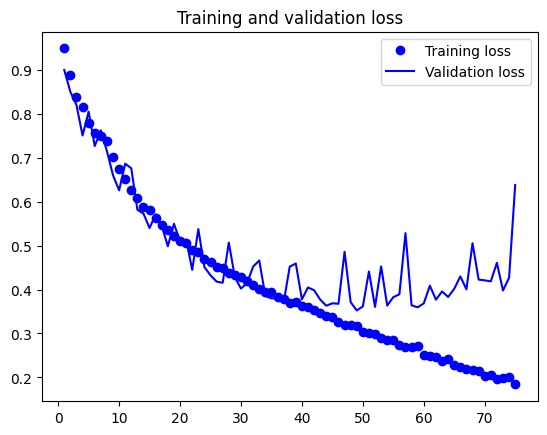

In [8]:
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
np.array([history.history['loss'], history.history['val_loss']]).T

array([[0.57847154, 0.58390915],
       [0.57874984, 0.58390915],
       [0.59533536, 0.6499458 ],
       [0.64090598, 0.69350427],
       [0.67740715, 0.65495181],
       [0.69454038, 0.70670891],
       [0.6969018 , 0.68329722],
       [0.69711387, 0.70509511],
       [0.71111894, 0.73137182],
       [0.72574311, 0.74603802],
       [0.73572958, 0.71959382],
       [0.74821335, 0.72569221],
       [0.75507092, 0.76710141],
       [0.76233512, 0.76843518],
       [0.7664969 , 0.78200555],
       [0.7744925 , 0.77090722],
       [0.77995396, 0.78094006],
       [0.78516167, 0.80207771],
       [0.79174519, 0.78205669],
       [0.79620314, 0.79648489],
       [0.79919237, 0.79864752],
       [0.80506098, 0.82548523],
       [0.80708277, 0.78560406],
       [0.8148067 , 0.823834  ],
       [0.81662488, 0.83076799],
       [0.82160693, 0.83562267],
       [0.82341135, 0.83705902],
       [0.82699662, 0.79906261],
       [0.82973713, 0.8320362 ],
       [0.83082712, 0.84297478],
       [0.

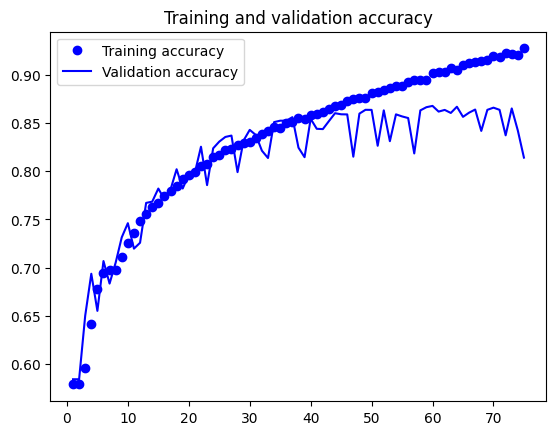

In [9]:
epochs = range(1, len(history.history['sparse_categorical_accuracy']) + 1)
accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']
plt.figure()
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
np.array([history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy']]).T